In [1]:
# Importing Libraries

import os
import numpy as np
import zipfile as zf

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten


In [2]:
files = zf.ZipFile("/content/flowers-images.zip", 'r')
files.extractall()
files.close()

In [4]:
# Fetch Images count from Folders

count = 0
dirs = os.listdir('flowers/')
for dir in dirs:
    files = list(os.listdir('flowers/'+dir))
    print( dir +' folder has '+ str(len(files)) + ' images')
    count = count + len(files)
print( 'flower folder has '+ str(count) + ' images')

sunflower folder has 733 images
tulip folder has 984 images
daisy folder has 764 images
rose folder has 784 images
dandelion folder has 1052 images
flower folder has 4317 images


In [6]:
# Load Images into Arrays as Dataset

base_dir = 'flowers/'
img_size = 180
batch = 32

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'training',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

val_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'validation',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [8]:
flower_names = train_ds.class_names
flower_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [9]:
import matplotlib.pyplot as plt

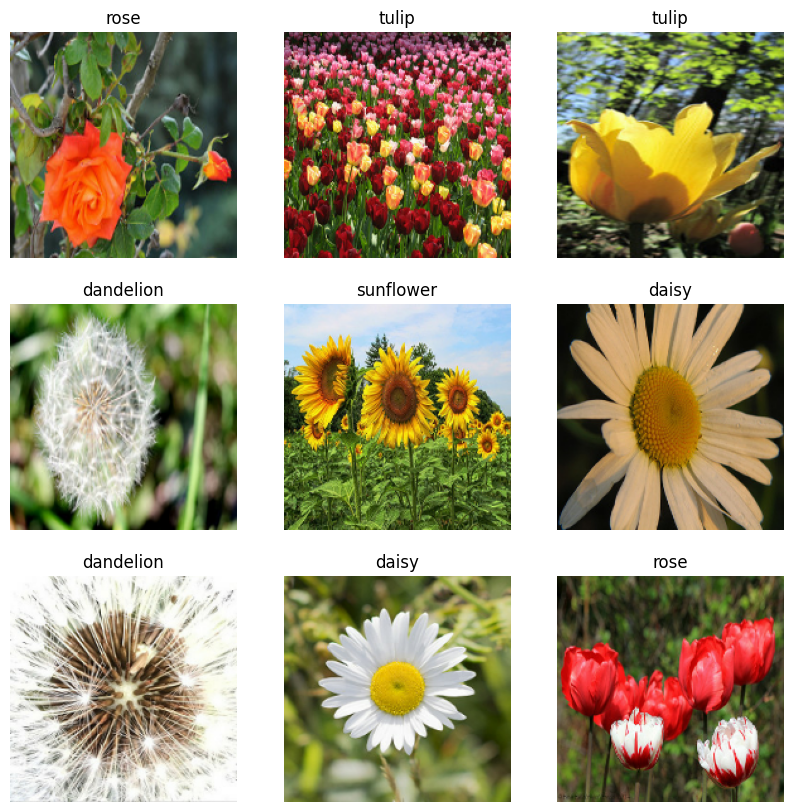

In [10]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(flower_names[labels[i]])
        plt.axis('off')

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [13]:
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [15]:
# Data Augmentation

data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

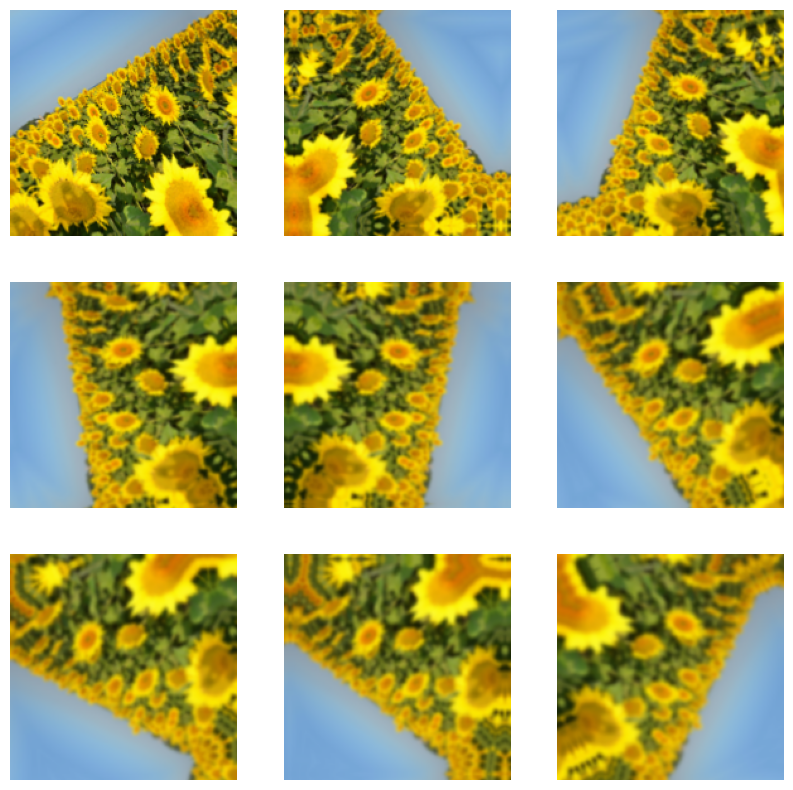

In [16]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [17]:
#MOdel Creation

In [18]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5)
])

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [21]:
history = model.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
108/108 [==============================] - 158s 1s/step - loss: 1.3737 - accuracy: 0.4357 - val_loss: 1.2560 - val_accuracy: 0.4959
Epoch 2/15
108/108 [==============================] - 134s 1s/step - loss: 1.1118 - accuracy: 0.5495 - val_loss: 1.0091 - val_accuracy: 0.5840
Epoch 3/15
108/108 [==============================] - 134s 1s/step - loss: 1.0073 - accuracy: 0.6164 - val_loss: 1.1558 - val_accuracy: 0.5666
Epoch 4/15
108/108 [==============================] - 137s 1s/step - loss: 0.9669 - accuracy: 0.6262 - val_loss: 0.9476 - val_accuracy: 0.6396
Epoch 5/15
108/108 [==============================] - 137s 1s/step - loss: 0.9071 - accuracy: 0.6465 - val_loss: 1.0233 - val_accuracy: 0.6141
Epoch 6/15
108/108 [==============================] - 134s 1s/step - loss: 0.8595 - accuracy: 0.6673 - val_loss: 0.9130 - val_accuracy: 0.6663
Epoch 7/15
108/108 [==============================] - 136s 1s/step - loss: 0.8368 - accuracy: 0.6833 - val_loss: 0.8323 - val_accuracy: 0.6756

In [22]:
def classify_images(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(180,180))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = tf.expand_dims(input_image_array,0)

    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    outcome = 'The Image belongs to ' + flower_names[np.argmax(result)] + ' with a score of '+ str(np.max(result)*100)
    return outcome

In [27]:
classify_images('/content/images.jpg')

1/1 [==============================] - 0s 98ms/step


'The Image belongs to rose with a score of 99.75932240486145'

In [28]:
model.save('flower_classification.h5')